Install required packages

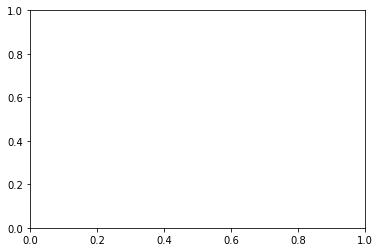

In [1]:
import matplotlib.pyplot as plt
plt.subplot()

In [2]:
%%capture
%pip install scanpy
%pip install scvi-tools==0.8.1
%pip install loompy
%pip install leidenalg

In [3]:
import torch 
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# System
import os, pathlib, time, gc

# Math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Plots
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# scvi
import anndata
import scvi
import torch


#from scvi.distributions import NegativeBinomial

In [6]:
import pdb

In [7]:
%cd "/content/drive/Shareddrives/scBIVI/scBIVI colab/scBIVI"
!ls

/content/drive/Shareddrives/scBIVI/scBIVI colab/scBIVI
analysis.py	     run.sh
bivae.py	     scBIVI-10-combined-4-train-history.pdf
data		     scBIVI-3-combined-4-train-history.pdf
distribution.py      scBIVI-6-combined-4-train-history.pdf
download_data.sh     scBIVIcustom-10-combined-4-train-history.pdf
experiment_colab.py  scBIVIcustom-3-combined-4-train-history.pdf
gena_snippets	     scBIVIcustom-6-combined-4-train-history.pdf
out		     scBIVI.ipynb
preprocess.py	     scBIVI.py
__pycache__	     scBIVIuncorr-10-combined-4-train-history.pdf
README.txt	     scBIVIuncorr-3-combined-4-train-history.pdf
requirements.txt     scBIVIuncorr-6-combined-4-train-history.pdf
run_scBIVI.py


In [8]:
# scbivi
from scBIVI import scBIVI
from analysis import calculate_accuracy, \
                     plot_corr_comparison, \
                     jaccard_index_split, \
                     knn_overlap


Manual scBIVI code

# Load data 

In [9]:
outdir = 'out/pbmc_10k_v3'
datadir = os.path.join(outdir,'data/preprocessed.h5ad')
logdir = os.path.join(outdir,'out')
percent_keep = 1
cluster_method_split = 'RNA_leiden'

## Load anndata
dataext = pathlib.Path(datadir).suffix
if dataext == '.h5ad':
    adata = anndata.read_h5ad(datadir)
elif dataext == '.loom':
    adata = anndata.read_loom(datadir)

## Downsample the data
if percent_keep < 1:
    X = adata.layers['counts']
    # Convert to numpy array if not already
    try:
        X = X.toarray()
    except:
        pass
    adata.layers['counts'] = np.random.binomial(X.astype('int32'),percent_keep)

# Set up train/test data splits with 5-fold split
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf_splits = skf.split(adata, adata.obsm['Cluster'][cluster_method_split])


# Run single instance for testing

Define hyper parameters and model (distribution) type

In [10]:
# Hyper-parameters
lr       = 1e-3
n_latent = 20 # overwritten by setup name
n_epochs = 10
# n_epochs = 20
n_hidden = 1024
n_layers = 2

# model setup
# scBIVI{dist}-{n_latent}-{data type}
# type: 
# setup = 'scBIVIcustom-10-combined'
# setup = 'scBIVI-10-combined'


In [11]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

# setups = [setup]
setups = ['scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined']

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
print(metrics_list)
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}
print(results_dict)
logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

['recon_error', 'latent embedding', 'compute', 'RNA_leiden']
{'scBIVIcustom-10-combined': {'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []}, 'scBIVI-10-combined': {'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []}, 'scBIVIuncorr-10-combined': {'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []}}


In [12]:
from torch._C import Value
from seaborn.axisgrid import PairGrid
# Define custom_dist if using scBIVIcustom


# Set to default bivariate as example
# from distribution import log_nb_positive_bi
# custom_dist = log_nb_positive_bi
def log_bursty_nb_bi_with_checks(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)



    # THETA_IS_MAT_SHAPE = True #this breaks at 5%
    # THETA_IS_B = False
    # THETA_IS_NAS_SHAPE = False
    
    # THETA_IS_MAT_SHAPE = False #best performance: breaks at 25%
    # THETA_IS_B = True
    # THETA_IS_NAS_SHAPE = False
    
    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True
    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2


    if torch.any(~torch.isfinite(gamma)):
        filt = ~torch.isfinite(gamma)
        print(gamma[filt])
        print(b[filt])
        print(beta[filt])
        print(mu1[filt])
        print(mu2[filt])
        print("bad gamma")
        raise ValueError
    if torch.any(~torch.isfinite(beta)):
        print("bad beta")
        raise ValueError
    if torch.any(~torch.isfinite(b)):
        print("bad b")
        raise ValueError

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    if torch.any(~torch.isfinite(logmean1)):
        print("bad logmean1")
        raise ValueError
    if torch.any(~torch.isfinite(logmean2)):
        print("bad logmean2")
        raise ValueError
    if torch.any(~torch.isfinite(logstd1)):
        print("bad logstd1")
        raise ValueError
    if torch.any(~torch.isfinite(logstd2)):
        print("bad logstd2")
        raise ValueError
    if torch.any(~torch.isfinite(cov)):
        print("bad cov")
        raise ValueError
    if torch.any(~torch.isfinite(logvar1)):
        print("bad logvar1")
        raise ValueError
    if torch.any(~torch.isfinite(logvar2)):
        print("bad logvar2")
        raise ValueError


    b = (logmean1 + logmean2 + (logvar1 + logvar2)/2)
    b[b<-88] = -88
    logcov = torch.log(cov * torch.exp(-(b)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)
    if torch.any(~torch.isfinite(logcov)):
        pdb.set_trace()
        print("bad logcov")
        print(logcov)
        raise ValueError
    if torch.any(~torch.isfinite(logcorr)):
        print("bad logcorr")
        raise ValueError

    if torch.any(torch.logical_or((logcorr<0), (logcorr>1))):
        print('excuse me haha what')
        filt = torch.logical_or((logcorr<0), (logcorr>1))
        print('params')
        # print(b[filt])/
        print(gamma[filt][10])
        print(beta[filt][10])
        # print()
        # print('logcov')
        # print(logcov[filt])
        # print('logcorr')
        # print(logcorr[filt])
        raise ValueError('Parameters are wrong!')

    if torch.any(~torch.isfinite(logcov)):
        raise ValueError("bad logcov")
    if torch.any(~torch.isfinite(logcorr)):
        raise ValueError("bad logcorr")

    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    # logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)   
    # logvar_cond = logstd_cond**2

    if torch.any(~torch.isfinite(logmean_cond)):
        raise ValueError("bad logmean_cond")
    if torch.any(~torch.isfinite(logcorr**2)):
        raise ValueError('bad square')
    if torch.any(~torch.isfinite((1-logcorr**2)**0.5)):
        print('bad sqrt')
        filt = ~torch.isfinite((1-logcorr**2)**0.5)
        # print('logstd cond')
        # print(logstd_cond[filt])
        print('logstd2')
        print(logstd2[filt])
        print('logcorr')
        print(logcorr[filt])
        print('sqrt')
        print(torch.sqrt(1-logcorr**2)   [filt])
        print('radical argument')
        print((1-logcorr**2)[filt])
        raise ValueError('Something weird in sqrt')
    if torch.any(~torch.isfinite(torch.sqrt(1-logcorr**2))):
        raise ValueError('bad torch.sqrt')
    # if torch.any(~torch.isfinite(logstd_cond)):
    #     print(logstd2)
    #     print(torch.sqrt(1-logcorr**2) )
    #     raise ValueError("bad logstd_cond")
    if torch.any(~torch.isfinite(logvar_cond)):
        raise ValueError("bad logvar_cond")


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)
    if torch.any(~torch.isfinite(mean_cond)):
        raise ValueError("bad mean_cond")
    if torch.any(~torch.isfinite(var_cond)):
        raise ValueError("bad var_cond")

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    if torch.any(~torch.isfinite(r)):
        raise ValueError("bad r")
    if torch.any(~torch.isfinite(prefactor)):
        raise ValueError("bad prefactor")


    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson mean
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    # y_ = torch.lgamma(m+r_cond) - torch.lgamma(m+1) - torch.lgamma(r_cond) \
                # + r_cond * torch.log(r_cond/(r_cond+mean_cond)) \
                # + m * torch.log(mean_cond/(r_cond+mean_cond))
    # y_ = torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(m[filt]+1) - torch.lgamma(r_cond[filt]) \
    #             + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])) \
    #             + m[filt] * torch.log(mean_cond[filt]/(r_cond[filt]+mean_cond[filt]))
    # y_[~filt] = m[~filt] * torch.log(mean_cond[~filt]) - mean_cond[~filt] - torch.lgamma(m[~filt]+1) 
    # print(y_.device)
    # print(y_.shape)
    # print(n.shape)
    # print(filt.shape)
    # print(y_.shape)
    # print(prefactor.shape)
    P = prefactor +  y_

    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P

def log_bursty_nb_bi(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True

    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2
    print(mu1)
    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    logcov = torch.log(cov * torch.exp(-(logmean1 + logmean2 + (logvar1 + logvar2)/2)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)


    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson term
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    #actually commenting out the next line fixes the Nan gradients... 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_
    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P


custom_dist = log_bursty_nb_bi_with_checks


In [13]:
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


The following seed settings work:
```
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)
```
Any others, who knows...

In [14]:
print(setups[0])

scBIVIcustom-10-combined


In [15]:
train_index_small = train_index[:100]
test_index_small = test_index[:50]

In [16]:
adata[train_index_small]

View of AnnData object with n_obs × n_vars = 100 × 5428
    obs: 'barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Spliced'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'Cluster', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [17]:
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)

SETUP=setups[0]

print(SETUP)
method,n_latent,datas = SETUP.split("-")
method_split = method.split('_')
method = method_split[0]

# If set up includes additional argument
additional_kwargs = {s.split('=')[0]: float(s.split('=')[1]) for s in method_split[1:]}
print(additional_kwargs)
n_latent = int(n_latent)

## Split the data
if datas == 'spliced':
  adata_in = adata[:,:int(adata.shape[1]/2)]
elif datas == 'unspliced':
  adata_in = adata[:,int(adata.shape[1]/2):]
elif datas == 'combined':
  adata_in = adata
else:
  raise ValueError("Input valid datas")

adata_in = adata_in.copy()
scvi.data.setup_anndata(adata_in, layer="counts")

train_adata, test_adata = adata_in[train_index], adata_in[test_index]
train_adata = train_adata.copy()

## Set model parameters
model_args = {'use_cuda'     : True,
              'n_latent'     : n_latent,
              'n_layers'     : n_layers,
              'dispersion'   : 'gene',
              'n_hidden'     : n_hidden,
              'dropout_rate' :  0.1, #shouldn't use this at all
              'gene_likelihood'    :  'nb',
              'log_variational'    :  True,
              'latent_distribution':  'normal'
              }
model_args.update(additional_kwargs)

## Create model
if method == 'LDVAE':
    model = scvi.model.LinearSCVI(train_adata,**model_args)
elif method == 'scVI':
    model = scvi.model.SCVI(train_adata,**model_args)
elif method == "scBIVI":
    model = scBIVI(train_adata,mode='corr',**model_args)
elif method == "scBIVIuncorr":
    model = scBIVI(train_adata,mode='uncorr',**model_args)
elif method == 'scBIVImixed':
    model = scBIVI(train_adata,mode='mixed',**model_args)
elif method == 'scBIVItemp':
    model = scBIVI(train_adata,mode='mixed',**model_args)
elif method == 'scBIVIcustom':
    print(method)
    model = scBIVI(train_adata,mode='custom',
                   custom_dist=custom_dist,**model_args)
else:
    raise Exception('Input valid scVI model')

## Train model
start = time.time()
# print(model)
model.train(n_epochs = n_epochs,
            lr       = lr,
            n_epochs_kl_warmup = n_epochs/2,
            metrics_to_monitor = ['reconstruction_error'],
            frequency = 1,
            train_size = 0.9)

scBIVIcustom-10-combined
{}
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
scBIVIcustom
INFO     Training for 10 epochs                                                                                    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)


INFO     KL warmup for 5.0 epochs                                                                                  
Training...: 100%|██████████| 10/10 [00:39<00:00,  3.90s/it]
INFO     Training time:  23 s. / 10 epochs                                                                         


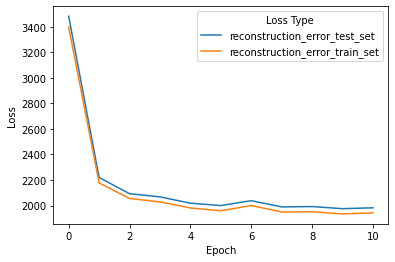

In [18]:
runtime     = time.time() - start
memory_used = torch.cuda.memory_allocated()
results_dict[SETUP]['compute'].append([runtime,memory_used])

## Check train history
df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
              'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
df_history = pd.DataFrame(df_history)
df_history = pd.DataFrame(df_history.stack())
df = df_history
df.reset_index(inplace=True)
df.columns = ['Epoch','Loss Type', 'Loss']
figname = f"{SETUP}-{k}"
sns.lineplot(data=df, 
             x='Epoch', 
             y='Loss', 
             hue = 'Loss Type')
# plt.savefig(os.path.join(logdir_train,f"{figname}-train-history.pdf"))
# plt.close()

In [20]:
## Get reconstruction loss on test data
test_error  = model.get_reconstruction_error(test_adata)
train_error = model.get_reconstruction_error(train_adata)
results_dict[SETUP]['recon_error'].append(np.array([train_error,test_error]))

## Extract the embedding space for scVI
X_out = model.get_latent_representation(test_adata)

adata_latent = anndata.AnnData(X_out)
adata_latent.obs = test_adata.obs
results_dict[SETUP]['latent embedding'] = adata_latent
if datas == 'combined':
  test_adata_save = test_adata

INFO     Received view of anndata, making copy.                                                                    
INFO     Received view of anndata, making copy.                                                                    


In [21]:
#### Validation with cluster accuracy based on labels
## Iterate through ground truth labels based on different approach

for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

    y = np.array(y.tolist())

    score_dict = calculate_accuracy(X_out,y)
    results_dict[SETUP][cluster_method].append(score_dict)

#### Get predicted distribution
if 'scBIVI' in method:

    params = model.get_likelihood_parameters(test_adata)
    mu = params['mean']
    if method == 'scBIVImixed':
        import torch.nn.functional as F
        mu,mw = np.split(mu,2,axis=1)
        mw_tensor = torch.tensor(mw.reshape(-1,int(mw.shape[1]/2),2))
        mw_softmax = F.softmax(mw_tensor/10e-20,dim=-1)

    mu1,mu2 = np.split(mu,2,axis=1)
    alpha = params['dispersions']

    if mu1.shape[1] == alpha.shape[1]:
        stats = {'mu1': mu1, 'mu2' : mu2,
                  '1/alpha'         : 1/alpha,
                  'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                  'mu2/alpha'       : mu2/alpha
                  }

        fig,axs = plt.subplots(1,len(stats),
                                figsize=(5*len(stats),4),
                                squeeze=False)

        for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
            ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
            ax.set_title(stat)

        # plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
        # plt.close()

#### Correlations

# cg = plot_corr_comparison(X1,X2)
# figname = f"{setup}-{k}"
# plt.title(figname)
# plt.savefig(os.path.join(logdir,f"{figname}-corr.pdf"))
# plt.close()

del model
torch.cuda.empty_cache()
gc.collect()


INFO     Received view of anndata, making copy.                                                                    


3073

here u go back and redefine `SETUPS`

In [22]:
results_dict.items()

dict_items([('scBIVIcustom-10-combined', {'recon_error': [array([-1946.74019158, -1948.66132509])], 'latent embedding': AnnData object with n_obs × n_vars = 2316 × 10
    obs: 'barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'compute': [[56.4795286655426, 416758784]], 'RNA_leiden': [{'ARI': 0.6699187429485802, 'NMI': 0.7943240297887311, 'silhouette': 0.17943446}]}), ('scBIVI-10-combined', {'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []}), ('scBIVIuncorr-10-combined', {'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []})])

In [23]:
for key,r in results_dict.items():
  print(key)
  print(r)

scBIVIcustom-10-combined
{'recon_error': [array([-1946.74019158, -1948.66132509])], 'latent embedding': AnnData object with n_obs × n_vars = 2316 × 10
    obs: 'barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'compute': [[56.4795286655426, 416758784]], 'RNA_leiden': [{'ARI': 0.6699187429485802, 'NMI': 0.7943240297887311, 'silhouette': 0.17943446}]}
scBIVI-10-combined
{'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []}
scBIVIuncorr-10-combined
{'recon_error': [], 'latent embedding': [], 'compute': [], 'RNA_leiden': []}


Empty DataFrame
Columns: [Train, Test, Setup]
Index: []


ValueError: ignored

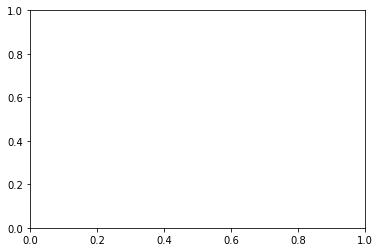

In [24]:
#### Plot NLL
setups = list(results_dict.keys())
# df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error']),
#                                    "Test": -np.array(r['recon_error']),
#                                    'Setup': key}) for key,r in results_dict.items()])
df_plot = pd.concat([pd.DataFrame({"Train": -np.array(results_dict['scBIVIuncorr-10-combined']['recon_error']),
                                    "Test": -np.array(results_dict['scBIVIuncorr-10-combined']['recon_error']),
                                    'Setup': key}) for key,r in results_dict.items()])
print(df_plot)
df_plot['KFold'] = df_plot.index
df_plot.reset_index(drop=True)

df_plot.to_csv(os.path.join(logdir,'.svg'))

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
# plt.savefig(os.path.join(logdir,'nll.svg'))
# plt.close()

#print(df_plot.groupby("Setup").mean())


                      Setup      Metric     Score
0  scBIVIcustom-10-combined         ARI  0.669919
1  scBIVIcustom-10-combined         NMI  0.794324
2  scBIVIcustom-10-combined  silhouette  0.179434


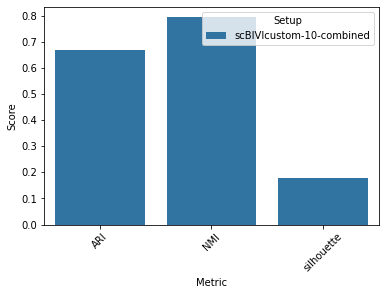

In [25]:
#### Plot clustering accuracy

# iterate through different cluster methods
for cluster_method in cluster_methods:
    df_plot = pd.concat([pd.DataFrame(r[cluster_method]).assign(Setup=key) for key,r in results_dict.items()])
    df_plot.to_csv(os.path.join(logdir,f'clust_acc_{cluster_method}.csv'))
    df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

    fig,ax=plt.subplots()
    _ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(logdir,f'clust_acc_{cluster_method}.svg'))
    # plt.close()
    print(df_plot)

# Loop through all K-folds split and setups

In [ ]:
print("{}/{}".format(torch.cuda.memory_allocated(),torch.cuda.max_memory_allocated()))

# Hyper-parameters
lr       = 1e-3
n_latent = 2
n_epochs = 10
n_hidden = 1024
n_layers = 3

#'scBIVIcustom-10-combined'
# setups = ['scBIVI-10-combined',
#           'scVI-10-combined',
#           "scVI-10-spliced",
#           'scVI-10-unspliced',
#           'scBIVIuncorr-10-combined',
#           'scBIVImixed-10-combined']
# setups = ['scBIVItemp_T=0.000001_Trate=0-10-combined']
setups = ['scBIVI-10-combined','scBIVIuncorr-10-combined']

# setups = ['scBIVI-10-combined',
#           'scBIVItemp_T=1_Trate=0.01-10-combined',
#           'scBIVItemp_T=1_Trate=0.0001-10-combined',
#           'scBIVItemp_T=1_Trate=0.000001-10-combined',
#           'scBIVItemp_T=1_Trate=0.00000001-10-combined',
#           'scBIVItemp_T=1_Trate=0-10-combined',
#           'scBIVItemp_T=0.01_Trate=0-10-combined',
#           'scBIVItemp_T=0.0001_Trate=0-10-combined',
#           'scBIVItemp_T=0.000001_Trate=0-10-combined',]

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

491550720/882992128


In [37]:
# train only one model

    ## Set model parameters
model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
model_args.update(additional_kwargs)

model = scBIVI(train_adata,mode='custom',**model_args)
model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                                                                  
Training...: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]
INFO     Training time:  12 s. / 10 epochs                                                                         


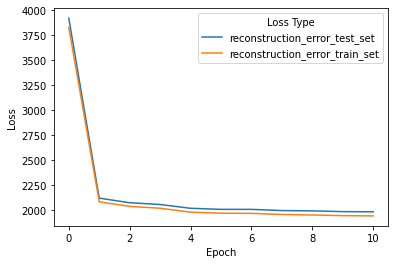

In [39]:
df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
df_history = pd.DataFrame(df_history)
df_history = pd.DataFrame(df_history.stack())
df = df_history
df.reset_index(inplace=True)
df.columns = ['Epoch','Loss Type', 'Loss']
figname = f"{setup}-{k}"
sns.lineplot(data=df,x='Epoch', y='Loss', hue = 'Loss Type')
plt.show()

In [45]:
params = model.get_likelihood_parameters(test_adata)
mu = params['mean']
mu1,mu2 = np.split(mu,2,axis=1)
alpha = params['dispersions']


print(test_adata)
print(mu1.shape)
print(alpha.shape)

INFO     Received view of anndata, making copy.                                                                    
View of AnnData object with n_obs × n_vars = 2316 × 5428
    obs: 'barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Spliced'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', '_scvi'
    obsm: 'Cluster', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
(2316, 5428)
(2316, 2714)


In [52]:
mu1.shape

(2316, 5428)

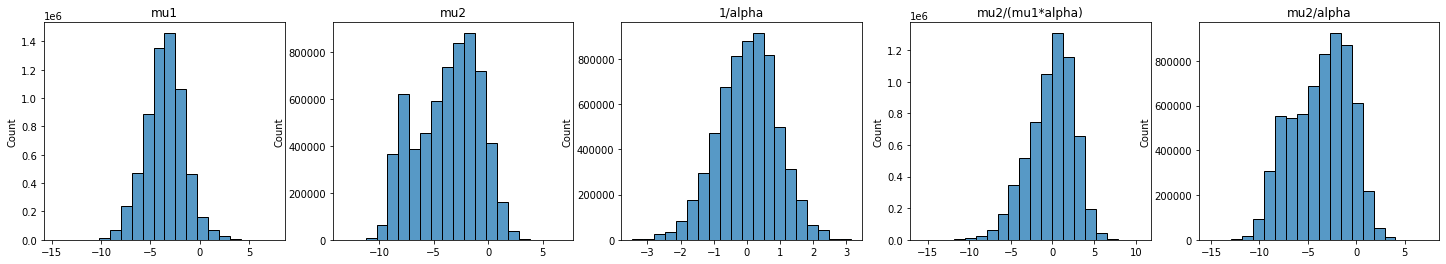

In [46]:
if mu1.shape[1] == alpha.shape[1]:
            stats = {'mu1': mu1, 'mu2' : mu2,
                     '1/alpha'         : 1/alpha,
                     'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                     'mu2/alpha'       : mu2/alpha
                     }

fig,axs = plt.subplots(1,len(stats),
                                   figsize=(5*len(stats),4),
                                   squeeze=False)

for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
  ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
  ax.set_title(stat)

            #plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
plt.show()

In [36]:
# for k, (train_index, test_index) in enumerate(skf_splits):
for q in range(1):
    #
  for setup in setups:
      #
    print(setup)
    method,n_latent,datas = setup.split("-")
    method_split = method.split('_')
    method = method_split[0]
    additional_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in method_split[1:]}

    n_latent = int(n_latent)

    ## Split the data
    if datas == 'spliced':
      adata_in = adata[:,:int(adata.shape[1]/2)]
    elif datas == 'unspliced':
      adata_in = adata[:,int(adata.shape[1]/2):]
    elif datas == 'combined':
      adata_in = adata
    else:
      raise ValueError("Input valid datas")

    adata_in = adata_in.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata, test_adata = adata_in[train_index], adata_in[test_index]
    train_adata = train_adata.copy()

    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    model_args.update(additional_kwargs)

    ## Create model
    if method == 'LDVAE':
        model = scvi.model.LinearSCVI(train_adata,**model_args)
    elif method == 'scVI':
        model = scvi.model.SCVI(train_adata,**model_args)
    elif method == "scBIVI":
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == "scBIVIuncorr":
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'scBIVImixed':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVItemp':
        # model_args['T'] = 1
        # model_args['Trate'] = 1
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVIcustom':
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    figname = f"{setup}-{k}"
    sns.lineplot(data=df,x='Epoch', y='Loss', hue = 'Loss Type')
    plt.show()
    #plt.savefig(os.path.join(logdir_train,f"{figname}-train-history.pdf"))
    plt.close()

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[setup]['recon_error'].append(np.array([train_error,test_error]))

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)

    if k == 0:
      adata_latent = anndata.AnnData(X_out)
      adata_latent.obs = test_adata.obs
      results_dict[setup]['latent embedding'] = adata_latent
      if datas == 'combined':
        test_adata_save = test_adata

    #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach

    for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

        y = np.array(y.tolist())

        score_dict = calculate_accuracy(X_out,y)
        results_dict[setup][cluster_method].append(score_dict)

    #### Get predicted distribution
    if 'scBIVI' in method:

        params = model.get_likelihood_parameters(test_adata)
        mu = params['mean']
        if method == 'scBIVImixed':
            import torch.nn.functional as F
            mu,mw = np.split(mu,2,axis=1)
            mw_tensor = torch.tensor(mw.reshape(-1,int(mw.shape[1]/2),2))
            mw_softmax = F.softmax(mw_tensor/10e-20,dim=-1)

        mu1,mu2 = np.split(mu,2,axis=1)
        alpha = params['dispersions']

        if mu1.shape[1] == alpha.shape[1]:
            stats = {'mu1': mu1, 'mu2' : mu2,
                     '1/alpha'         : 1/alpha,
                     'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                     'mu2/alpha'       : mu2/alpha
                     }

            fig,axs = plt.subplots(1,len(stats),
                                   figsize=(5*len(stats),4),
                                   squeeze=False)

            for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
                ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
                ax.set_title(stat)

            #plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
            plt.show()
            plt.close()

    #### Correlations

    # cg = plot_corr_comparison(X1,X2)
    # figname = f"{setup}-{k}"
    # plt.title(figname)
    # plt.savefig(os.path.join(logdir,f"{figname}-corr.pdf"))
    # plt.close()

    del model
    torch.cuda.empty_cache()
    gc.collect()


scBIVIcustom-3-combined
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs               

KeyboardInterrupt: ignored

In [33]:
results_dict

{'scBIVI-10-combined': {'RNA_leiden': [{'ARI': 0.6630321260937057,
    'NMI': 0.8006713916005536,
    'silhouette': 0.15603742}],
  'compute': [[18.158941507339478, 283231232]],
  'latent embedding': [],
  'recon_error': [array([-1934.82882488, -1941.74690165])]},
 'scBIVI-3-combined': {'RNA_leiden': [{'ARI': 0.6455296635498786,
    'NMI': 0.7884530554835861,
    'silhouette': 0.20503378}],
  'compute': [[18.153576374053955, 282887168]],
  'latent embedding': [],
  'recon_error': [array([-1949.52892691, -1949.2402192 ])]},
 'scBIVI-6-combined': {'RNA_leiden': [{'ARI': 0.7030401462223084,
    'NMI': 0.8079370704328609,
    'silhouette': 0.20217}],
  'compute': [[18.06775188446045, 283034624]],
  'latent embedding': [],
  'recon_error': [array([-1948.82337426, -1953.47135417])]},
 'scBIVIcustom-10-combined': {'RNA_leiden': [{'ARI': 0.568883981650096,
    'NMI': 0.7299676796988561,
    'silhouette': 0.06552089}],
  'compute': [[23.476929187774658, 416758784]],
  'latent embedding': [],
  

More stuff

In [ ]:
custom_dist = log_bursty_nb_bi_with_checks

NameError: ignored

In [27]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

# setups = [setup]
# setups = ['scBIVIcustom-6-combined','scBIVI-6-combined','scBIVIuncorr-6-combined',\
        #   'scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]
setups = ['scBIVIcustom-3-combined','scBIVI-3-combined','scBIVIuncorr-3-combined',\
          'scBIVIcustom-6-combined','scBIVI-6-combined','scBIVIuncorr-6-combined',\
          'scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]
# setups = ['scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

for SETUP in setups:

    # SETUP=setups[2]

    print(SETUP)
    method,n_latent,datas = SETUP.split("-")
    method_split = method.split('_')
    method = method_split[0]

    # If set up includes additional argument
    additional_kwargs = {s.split('=')[0]: float(s.split('=')[1]) for s in method_split[1:]}

    n_latent = int(n_latent)

    if n_latent == 3:
        sd = 6
    if n_latent == 6:
        sd = 4
    if n_latent==10:
        sd = 8675309
    scvi._settings.ScviConfig.seed=(sd)
    torch.manual_seed(sd)
    np.random.seed(sd)

    ## Split the data
    if datas == 'spliced':
        adata_in = adata[:,:int(adata.shape[1]/2)]
    elif datas == 'unspliced':
        adata_in = adata[:,int(adata.shape[1]/2):]
    elif datas == 'combined':
        adata_in = adata
    else:
        raise ValueError("Input valid datas")

    adata_in = adata_in.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata, test_adata = adata_in[train_index], adata_in[test_index]
    train_adata = train_adata.copy()

    ## Set model parameters
    model_args = {'use_cuda'     : True,
                'n_latent'     : n_latent,
                'n_layers'     : n_layers,
                'dispersion'   : 'gene',
                'n_hidden'     : n_hidden,
                'dropout_rate' :  0.1, #shouldn't use this at all
                'gene_likelihood'    :  'nb',
                'log_variational'    :  True,
                'latent_distribution':  'normal'
                }
    model_args.update(additional_kwargs)

    ## Create model
    if method == 'LDVAE':
        model = scvi.model.LinearSCVI(train_adata,**model_args)
    elif method == 'scVI':
        model = scvi.model.SCVI(train_adata,**model_args)
    elif method == "scBIVI":
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == "scBIVIuncorr":
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'scBIVImixed':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVItemp':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVIcustom':
        print(method)
        model = scBIVI(train_adata,mode='custom',
                    custom_dist=custom_dist,**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    # print(model)
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)
    
    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[SETUP]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    figname = f"{SETUP}-{k}"
    sns.lineplot(data=df, 
                x='Epoch', 
                y='Loss', 
                hue = 'Loss Type')
    plt.savefig(f"{figname}-train-history.pdf")

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[SETUP]['recon_error'].append(np.array([train_error,test_error]))

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)

    adata_latent = anndata.AnnData(X_out)
    adata_latent.obs = test_adata.obs
    results_dict[SETUP]['latent embedding'] = adata_latent
    if datas == 'combined':
        test_adata_save = test_adata
    # plt.close()

        #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach

    for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

        y = np.array(y.tolist())

        score_dict = calculate_accuracy(X_out,y)
        results_dict[SETUP][cluster_method].append(score_dict)

    del model
    torch.cuda.empty_cache()
    gc.collect()


scBIVIcustom-3-combined
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
scBIVIcustom
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs  

KeyboardInterrupt: ignored

                                Train         Test  KFold
Setup                                                    
scBIVI-10-combined        1934.828825  1941.746902    0.0
scBIVI-3-combined         1949.528927  1949.240219    0.0
scBIVI-6-combined         1948.823374  1953.471354    0.0
scBIVIcustom-10-combined  4693.319576  4534.523311    0.0
scBIVIcustom-3-combined   1940.196851  1939.527084    0.0
scBIVIcustom-6-combined   1927.721610  1930.784750    0.0
scBIVIuncorr-10-combined  1926.446148  1933.225265    0.0
scBIVIuncorr-3-combined   1946.248499  1944.102215    0.0
scBIVIuncorr-6-combined   1933.985715  1937.579298    0.0


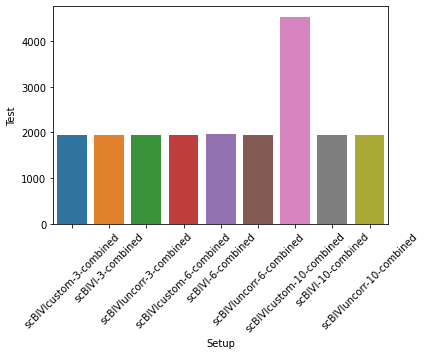

In [34]:
#### Plot NLL
setups = list(results_dict.keys())
df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error'])[:,0],
                                   "Test": -np.array(r['recon_error'])[:,1],
                                   'Setup': key}) for key,r in results_dict.items()])

df_plot['KFold'] = df_plot.index
df_plot.reset_index(drop=True)

df_plot.to_csv(os.path.join(logdir,'.svg'))

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
# plt.savefig(os.path.join(logdir,'nll.svg'))
# plt.close()

print(df_plot.groupby("Setup").mean())


                       Setup      Metric     Score
0    scBIVIcustom-3-combined         ARI  0.663448
1          scBIVI-3-combined         ARI  0.645530
2    scBIVIuncorr-3-combined         ARI  0.695304
3    scBIVIcustom-6-combined         ARI  0.697061
4          scBIVI-6-combined         ARI  0.703040
5    scBIVIuncorr-6-combined         ARI  0.664446
6   scBIVIcustom-10-combined         ARI  0.568884
7         scBIVI-10-combined         ARI  0.663032
8   scBIVIuncorr-10-combined         ARI  0.703712
9    scBIVIcustom-3-combined         NMI  0.787442
10         scBIVI-3-combined         NMI  0.788453
11   scBIVIuncorr-3-combined         NMI  0.806977
12   scBIVIcustom-6-combined         NMI  0.811554
13         scBIVI-6-combined         NMI  0.807937
14   scBIVIuncorr-6-combined         NMI  0.795084
15  scBIVIcustom-10-combined         NMI  0.729968
16        scBIVI-10-combined         NMI  0.800671
17  scBIVIuncorr-10-combined         NMI  0.817692
18   scBIVIcustom-3-combined  s

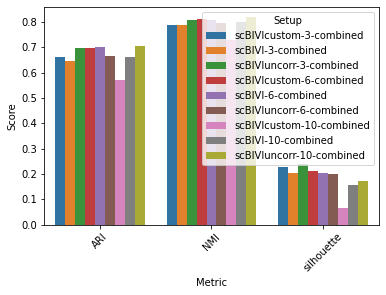

In [35]:
#### Plot clustering accuracy

# iterate through different cluster methods
for cluster_method in cluster_methods:
    df_plot = pd.concat([pd.DataFrame(r[cluster_method]).assign(Setup=key) for key,r in results_dict.items()])
    df_plot.to_csv(os.path.join(logdir,f'clust_acc_{cluster_method}.csv'))
    df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

    fig,ax=plt.subplots()
    _ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(logdir,f'clust_acc_{cluster_method}.svg'))
    # plt.close()
    print(df_plot)

### Define custom model 


To run the custom model (bursty transcription, splicing, degradation) that is approximated by the neural network, run the cells below.


Then, you can run inference with code above. 




In [ ]:

import sys
sys.path.insert(0,'/content/drive/My Drive/scBIVI_mc/scBIVI/')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import stats

In [ ]:
from scvi.core.distributions import NegativeBinomial

In [ ]:
# define model to load in 
# define model
class MLP(nn.Module):

    def __init__(self, input_dim, npdf, h1_dim, h2_dim):
        super().__init__()

        self.input = nn.Linear(input_dim, h1_dim)
        self.hidden = nn.Linear(h1_dim, h2_dim)
        self.output = nn.Linear(h2_dim, npdf)

        self.hyp = nn.Linear(h1_dim,1)

        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = torch.sigmoid
        

    def forward(self, inputs):

        # pass inputs to first layer, apply sigmoid
        l_1 = self.sigmoid(self.input(inputs))

        # pass to second layer, apply sigmoid
        l_2 = self.sigmoid(self.hidden(l_1))
        
        # pass to output layer 
        w_un = (self.output(l_2))
        
        # pass out hyperparameter, sigmoid so it is between 0 and 1, then scale between 1 and 6
        hyp = self.sigmoid(self.hyp(l_2))
    
        # apply softmax
        w_pred = self.softmax(w_un)

        return w_pred,hyp

In [ ]:
model_path = '/content/drive/My Drive/scBIVI_mc/scBIVI/models/best_model_MODEL'  

# load in model
model_bursty = MLP(7,10,256,256)
model_bursty.load_state_dict(torch.load(model_path))
model_bursty.eval()     
model_bursty.to(torch.device('cuda'))

MLP(
  (input): Linear(in_features=7, out_features=256, bias=True)
  (hidden): Linear(in_features=256, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (hyp): Linear(in_features=256, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
# define NORM and lnfactorial

def get_NORM(npdf):
    '''' Returns quantiles based on the number of kernel functions npdf. 
    Chebyshev quantiles.'''
    n = np.arange(npdf)
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2)

    norm = stats.norm.ppf(q)
    norm = torch.tensor(norm)
    return norm


# precalcualte norm, move to device
NORM = get_NORM(10).to(torch.device('cuda'))
# precalculate lngammas
lnfactorial = torch.special.gammaln(torch.arange(2000)).to(torch.device('cuda'))

In [ ]:
# define translin (grid thing) and new get_ypred_at_RT
def generate_grid(logmean_cond,logstd_cond, NORM = NORM):
    ''' Generate grid of kernel means based on the log mean and log standard devation of a conditional distribution.
    Generates the grid of quantile values in NORM, scaled by conditional moments.
    -------
    '''


    a = logstd_cond.reshape(-1,1) * NORM
    translin = torch.exp(torch.add(logmean_cond.reshape(-1,1),a))
    print('TRANSLIN DEVICE:' , translin.device)
    
    return translin

def get_ypred_at_RT(p,w,hyp,n_feed,m_feed,norm=NORM):
    '''Given a parameter vector (tensor) and weights (tensor), and hyperparameter,
    calculates ypred (Y), or approximate probability. Calculates over array of nascent (n_feed) and mature (m_feed) values.
    '''
        
    p_vec = 10**p[:,0:3]
    logmean_cond = p[:,3]
    logstd_cond = p[:,4]
    
    
    hyp = hyp*5+1
    
    npdf = w.shape[1]
        
    grid = generate_grid(logmean_cond,logstd_cond,norm)
    s = torch.zeros((len(n_feed),npdf)).to(torch.device('cuda'))
    s[:,:-1] = torch.diff(grid,axis=1)
    s *= hyp
    s[:,-1] = torch.sqrt(grid[:,-1])
  
    
    v = s**2
    r = grid**2/(v-grid)
    p_nb = 1-grid/v
    
    xgrid = m_feed
    Y = torch.zeros((len(n_feed),1)).to(torch.device('cuda'))
    m_index = m_feed.long()
    GAMMALN_XGRID = torch.tensor([lnfactorial[m] for m in m_index]).reshape((-1,1))
    
    for i in range(npdf):
        grid_i = grid[:,i].reshape((-1,1))


        r_i = r[:,i].reshape((-1,1))
        w_i = w[:,i].reshape((-1,1))
        p_nb_i = p_nb[:,i]
        
        l = -grid_i + torch.mul(xgrid,torch.log(grid_i )) - GAMMALN_XGRID[i,0]

        if (p_nb_i > 1e-10).any():

            index = [p_nb_i > 1e-10]
            l[index] += torch.special.gammaln(xgrid[index]+r_i[index]) - torch.special.gammaln(r_i[index]) \
                - xgrid[index]*torch.log(r_i[index] + grid_i[index]) + grid_i[index] \
                + r_i[index]*torch.log(r_i[index]/(r_i[index]+grid_i[index]))

        Y += torch.mul(w_i,torch.exp(l))
    

    EPS = 1e-40
    Y[Y<EPS]=EPS
    return torch.log(Y)

In [ ]:
def custom_dist_bursty(x: torch.tensor, mu1: torch.tensor, mu2: torch.tensor,
                       theta: torch.tensor, mw, eps):
    
    
    ''' 
    x : anndata object containing unspliced/spliced RNA
    
    mu1 : mean of nascent RNA (output from DecoderSCVI)
    
    mu2 : mean of mature RNA (output from DecoderSCVI)
    
    theta : shape parameter (NAS or MAT shape , correlation)? 
        -- how to interpret physically ? 
        
    Takes output from SCVI model and calculates the probability of data given the bursty, two-species model of transcription.
    Uses best model. 
    '''
    
    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    print('MU 1 ---------')
    print(mu1)
    
    # calculate parameter vectors
    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True

    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2
        
    # negative binomial probability of n
    # using scvi's distributions:
    # Negative Binomial can be parameterized by mean and inverse dispersion, so mu1 and theta
    # if THETA = NAS_SHAPE
    neg_binomials = NegativeBinomial(mu=mu1, theta=theta)
    prob_n = neg_binomials.log_prob(n)
    # are these log or absolute predicted mu1, mu2, theta -- i think absolute ? 
    
    # calculate variances, covariance, 
    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    xmax_m = mu2 + 4*torch.sqrt(var2)
    
    # moments for negative binomial parameterization
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    logcov = torch.log(cov * torch.exp(-(logmean1 + logmean2 + (logvar1 + logvar2)/2)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)

    # conditional moments 
    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logstd_cond = logstd1 * torch.sqrt(1-logcorr**2) 
    
    # now, stack for model
    # then, reshape to feed through model
    b_feed = torch.log(b).reshape((-1,1))
    beta_feed = torch.log(beta).reshape((-1,1))
    gamma_feed = torch.log(gamma).reshape((-1,1))
    logmean_cond_feed = logmean_cond.reshape((-1,1))
    logstd_cond_feed = logstd_cond.reshape((-1,1))
    xmax_m_feed = xmax_m.reshape((-1,1))

    # reshape m and n values
    m_feed = m.reshape((-1,1))
    m_feed = m.reshape((-1,1))
    n_feed = n.reshape((-1,1))
    n_feed = n.reshape((-1,1))

    print('n and m device',n_feed.device)

    # create array of conditional rate vectors 
    rate_vectors = torch.column_stack((b_feed,beta_feed,gamma_feed,logmean_cond_feed,logstd_cond_feed,
                                    xmax_m_feed,n_feed))



    # feed rate vectors through model to get weights and hyperparameter
    w_,hyp_= model_bursty(rate_vectors)

    # get conditional probabilites
    ypred_cond = get_ypred_at_RT(rate_vectors,w_,hyp_,n_feed,m_feed,NORM)
    ypred_cond = ypred_cond.reshape(n.shape)
    # multiply conditionals P(m|n) by P(n)
    predicted = prob_n + ypred_cond
    
    return(predicted)